In [1]:
import numpy as np
import pandas as pd
import struct
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('darkgrid')
import sys
import os

In [2]:
def read_file(file_name):
    array = np.loadtxt(file_name)
    data = list(zip(*array))
    return data

def plot_multiple(data, data_name, data_xlabel, data_ylabel, legend_names): # plot several results together
    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = True, figsize=(10,7))
    m = []
    axes.set_title(data_name)
    axes.set_xlabel(data_xlabel)
    axes.set_ylabel(data_ylabel)
    for j in range(len(data)):
        m1 = axes.errorbar(data[j][0], data[j][1], yerr = data[j][2])
        m.append(m1)
    axes.legend(m, legend_names)
    plt.show()
    plt.clf()
    
def get_potential(data_path, T1):
    T = T1 - 1
    x = []
    y = []
    y_err = []
    for i in range(1, 17):
        data= read_file(data_path + '%d' % (i))
        y.append(math.log(data[1][T]/data[1][T+1]))
        y_err.append(math.sqrt( (data[2][T]/data[1][T])*(data[2][T]/data[1][T]) + (data[2][T+1]/data[1][T+1])*(data[2][T+1]/data[1][T+1])) )
        x.append(i)
    return x, y, y_err

def merge(data1, data2):
    data = []
    x = []
    y = []
    y_err = []
    for i in range(len(data1[1])):
        x.append(data1[0][i])
        y.append(data1[1][i] + data2[1][i])
        y_err.append(data1[2][i] + data2[2][i])
    return x, y, y_err
    
def potential_plot_multiple(T, mu):
    data = []
    w=mu//10
    q=mu-w*10
    data.append(get_potential('/home/ilya/lattice/observables/data/wilson_loop/mon_wl/mu0.%d%d/potential_R=' % (w, q), T))
    data.append(get_potential('/home/ilya/lattice/observables/data/wilson_loop/offd/HYP_APE/mu0.%d%d/potential_R=' % (w, q), T))
    data.append(get_potential('/home/ilya/lattice/observables/data/wilson_loop/mag/HYP_APE/mu0.%d%d/potential_R=' % (w, q), T))
    data.append(merge(data[0], data[1]))
    #print(data[1], data[2], data[3])
    plot_multiple(data, 'potential', 'R', 'V(R)', ['mon_wl', 'offd', 'mag', 'mon_wl + offd'])
    plt.show()
    plt.clf()
    
def potential_plot(N): #build plot for longitudinal
    T = N - 6
    x = []
    y = []
    y_err = []
    for i in range(1, 21):
        data= read_file('/home/ilya/lattice/observables/data/wilson_loop/qc2dstag/HYP_APE/mu0.05/potential_R=%d' % (i))
        #print(i, data[1][T]/data[1][T+1])
        y.append(math.log(data[1][T]/data[1][T+1]))
        #y.append(data[1][T])
        #y_err.append(data[2][T])
        y_err.append(math.sqrt( (data[2][T]/data[1][T])*(data[2][T]/data[1][T]) + (data[2][T+1]/data[1][T+1])*(data[2][T+1]/data[1][T+1])) )
        x.append(i)
    plt.errorbar(x, y, yerr=y_err)
    plt.show()
    plt.clf()
    
def potential_time(R):
    x = []
    y = []
    y_err = []
    for T in range(10):
        data= read_file('/home/ilya/lattice/observables/data/wilson_loop/su2/APE/mu0.00/potential_R=%d' % (R))
        #print(T, data[1][T]/data[1][T+1])
        y.append(log(data[1][T]/data[1][T+1]))
        #y.append(data[1][T])
        y_err.append(math.sqrt( (data[2][T]/data[1][T])*(data[2][T]/data[1][T]) + (data[2][T+1]/data[1][T+1])*(data[2][T+1]/data[1][T+1])))
        x.append(T+6)
    plt.errorbar(x, y, yerr=y_err)
    plt.show()
    plt.clf()

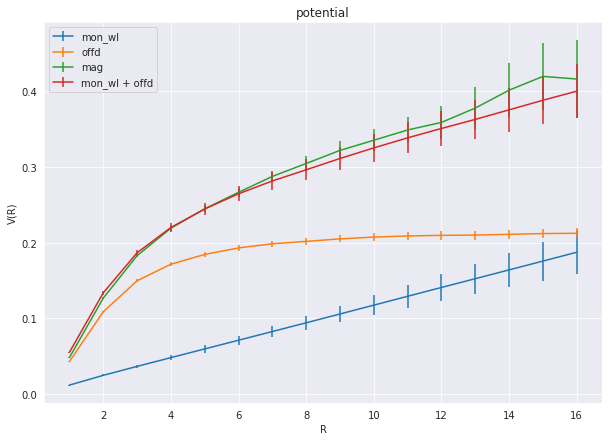

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [3]:
potential_plot_multiple(10, 0)

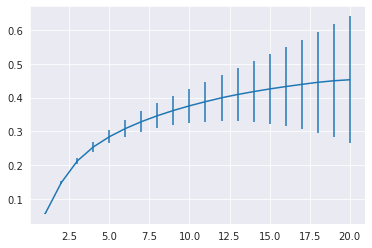

<Figure size 432x288 with 0 Axes>

In [13]:
potential_plot(6)

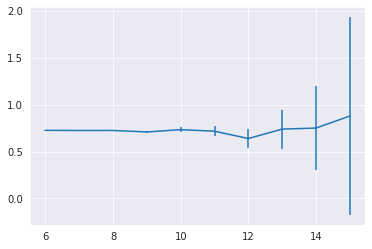

<Figure size 432x288 with 0 Axes>

In [216]:
potential_time(13)